(array([[[493., 236.],
        [539., 258.],
        [517., 303.],
        [472., 281.]]], dtype=float32),)
[[[-2.5119578  -0.57403747  1.36903263]]]
[[[2.37685991e-02 2.96543909e-02 2.80820057e+01]]]
angle:  -0.48581989742798454
angle in degrees: -27.83542972610207


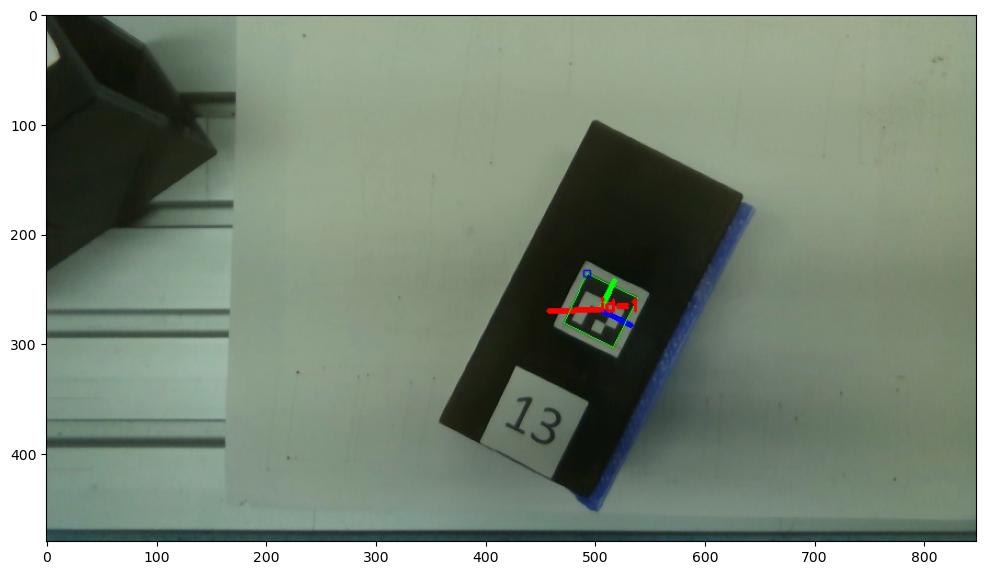

In [53]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import rtde_control
import rtde_receive
import numpy
import math
rtde_r = rtde_receive.RTDEReceiveInterface("169.254.37.182")
rtde_c = rtde_control.RTDEControlInterface("169.254.37.182")


#Capturing position
rtde_c.moveL([-0.1652, -0.78755, 0.14230, 0.022, -3.154, -0.017], 0.5, 0.3)
time.sleep(1)


# Intrensic Matrix Obtained from Camera Calibration
n_mtx = [[5.23058487e+04,0.00000000e+00,4.61024155e+02],[0.00000000e+00,2.81347874e+04,2.39792318e+02],[0.00000000e+00,0.00000000e+00,1.00000000e+00]]
mtx = np.array(n_mtx)
# Distortion Matrix Obtained from Camera Calibration 
n_dist = [5.41119138e+01,-1.12643444e+04,3.13452550e-02,-3.04059948e-01,-4.39888679e+01]
dist = np.array(n_dist)


# Capturing the frame by using Display function
def display(img):
    fig=plt.figure(figsize=(12,10))
    ax=fig.add_subplot(111)
    ax.imshow(img)
# Define dictionary for marker detection
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_100)
# Define parameters for marker detection
parameters = cv2.aruco.DetectorParameters_create()
# Create video capture object
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 848)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(5,30)
t1=time.time()
while True:
    # Read frame from camera
    ret, frame = cap.read()
    t2=time.time()
    if (t2-t1>=1):
        break
# Save frame as image file
cap.release()
cv2.imwrite('aruco.jpg',frame)


# Reading the captured Image
img = cv2.imread("C:/Users/Prajwal/Python Projects/Weimar SRA/TRIALS 1/Random Pose1/aruco.jpg")
# Convert frame to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect markers in the frame
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
print(corners)
if ids is not None:
    # Estimate pose of each marker
    rvec, tvec, _ = cv2.aruco.estimatePoseSingleMarkers(corners, 0.05, mtx, dist)
    # Draw axes on the frame for each marker
    for i in range(ids.size):
        result_img = cv2.drawFrameAxes(img, mtx, dist, rvec[i, :, :], tvec[i, :, :], 0.03)
        # Store the pixel coordinates of the corners for each detected marker
    # Draw marker borders and IDs on the frame
    cv2.aruco.drawDetectedMarkers(img, corners, ids)
# Display the frame
display(img)

# Inverse of Reference Rotation matrix
ref_mat_inv= [[0.54436054,-0.03173908,-0.8382507],[-0.0135869,-0.99948647,0.02902069],[-0.83874132,-0.00440849,-0.54451223]]

# Rotation vector obtained from ArUco marker
rot_vec = np.array([rvec[0][0][0],rvec[0][0][1],rvec[0][0][2]])

# Obtain the rotation matrix from the rotation vector
rot_mat, _ = cv2.Rodrigues(rot_vec)
# Ref_rot_mat x Rot_mat_of_comp
result = np.dot(ref_mat_inv, rot_mat)
# Finding the angle of the ARuco wrt camera frame
angle=np.arcsin(result[1][0])
print('angle: ',angle)
print('angle in degrees:',math.degrees(angle))

# Rotating the TCP as per the angle obtained
q=rtde_r.getActualQ()
angle=angle + math.radians(90)
q[5]-= angle
rtde_c.moveJ(q, 0.5, 0.3)

# Moving down in z-axis to pick the component
actual_p=rtde_r.getActualTCPPose()
z_pos=actual_p[2]
actual_p[2]=0.015
rtde_c.moveL(actual_p)

rtde_r.disconnect()
rtde_c.disconnect()

In [18]:
import math
print(math.radians(90))

1.5707963267948966
